# Convolutional neural networks for artistic style transfer

This iPython notebook demonstrates how to use neural networks to transfer artistic style from one image onto another.

## Imports

In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time

import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K

def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

Using TensorFlow backend.


## Load input images
We will need two images from which we will extract the content and the style. We have already made available some content and style images to use in this exercise, but fell free to use other images as well. The `base_image_path` is the path to the content image and `style_reference_image_path` to the style image.

We will also define the number of iterations to optimize the combination image and the weights of each loss that our algorithm will optimize on.

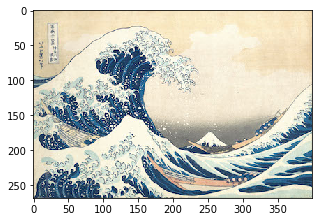

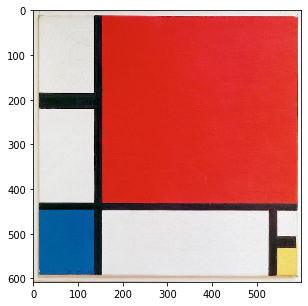

In [2]:
base_image_path = "Tsunami_by_hokusai_19th_century.jpg" 
plotImage(load_img(base_image_path))

style_reference_image_path = "Piet_Mondriaan,_1930_-_Mondrian_Composition_II_in_Red,_Blue,_and_Yellow.jpg"
plotImage(load_img(style_reference_image_path))

iterations = 5

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 5.0
content_weight = 0.025

Due to memory and time, we will be limiting both dimensions of our images in 250, while keeping the aspect ratio.

In [3]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size

if width >= height:
    img_ncols = 250
    img_nrows = int(height * img_ncols / width)
else: 
    img_nrows = 250
    img_ncols = int(width * img_nrows / height)

## Utility methods
These are the utility methods that are used throughout this notebook:
- `preprocess_image`: load and preprocess an input image;
- `deprocess_image`: transform the optimized output back to an image, basically by reverting `preprocess_image`;
- `plotImage`: plot a previously loaded image;
- `eval_loss_and_grads`: just process the loss and gradients computed by our algorithm;
- `Evaluator` class: just an efficiency trick to compute the loss and gradient only once;

In [4]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

## Network setup
Let's load VGG and prepare the input and output tensors.

In [5]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                     weights=None, include_top=False)
model.load_weights("vggWeights.h5")

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Now that the architecture is ready, we shall define the losses that we will optimize our network.

## Style Loss 

In [6]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

## Content Loss

In [7]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

## Total Variation Loss

In [8]:
# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# Combine all three losses and get gradients

In [9]:
# combine these loss functions into a single scalar
loss = K.variable(0.)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)


# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Optimize the Combined Image
Now let the optimization begin!

Start of iteration 0
Current loss value: 100353680000.0
Iteration 0 completed in 42s


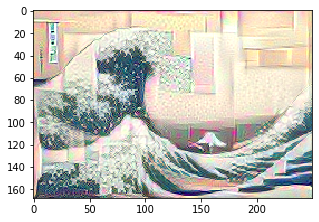

Start of iteration 1
Current loss value: 54374020000.0
Iteration 1 completed in 44s


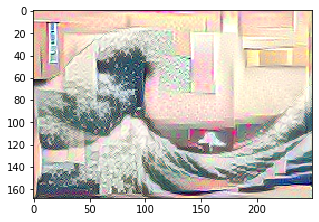

Start of iteration 2
Current loss value: 37473903000.0
Iteration 2 completed in 46s


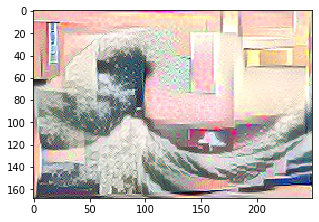

Start of iteration 3
Current loss value: 29552130000.0
Iteration 3 completed in 44s


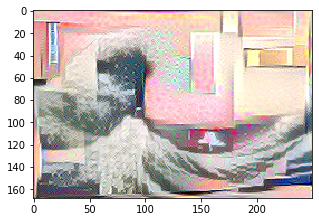

Start of iteration 4
Current loss value: 25079384000.0
Iteration 4 completed in 43s


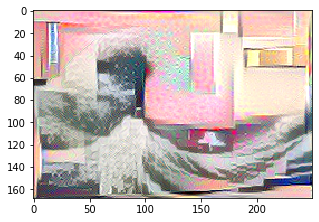

In [10]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    end_time = time.time()
    print('Current loss value:', min_val)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))    
    plotImage(deprocess_image(x.copy()))
    save_img("result_it_" + str(i) + ".png", deprocess_image(x.copy()))

## References
- [Keras example on Style Transfer](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py)
- [Style Transfer with VGG16](https://github.com/hnarayanan/artistic-style-transfer/blob/master/notebooks/6_Artistic_style_transfer_with_a_repurposed_VGG_Net_16.ipynb)